In [1]:
import sys
sys.path.append("../") # adding the path to read the utils file
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import CatBoostClassifier
from sklearn import metrics, tree
from shap import TreeExplainer
import fasttreeshap
from shap import plots, Explanation
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
import shap
from utils import *
import pickle
from yellowbrick.classifier import ROCAUC
from yellowbrick.contrib.wrapper import wrap

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_hikari, usecols=selected_features_hikari),
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_hikari, usecols=selected_features_hikari)], 
    ignore_index=True)
ds.head()

flow_duration  fwd_pkts_tot  bwd_pkts_tot  fwd_data_pkts_tot  \
0       2.207588            15            14                  6   
1      15.624266            15            14                  6   
2      12.203357            14            13                  6   
3       9.992448            14            13                  6   
4       7.780611            14            14                  6   

   bwd_data_pkts_tot  fwd_pkts_per_sec  bwd_pkts_per_sec  flow_pkts_per_sec  \
0                  6          6.794746          6.341763          13.136509   
1                  6          0.960045          0.896042           1.856087   
2                  5          1.147225          1.065281           2.212506   
3                  5          1.401058          1.300983           2.702041   
4                  5          1.799345          1.799345           3.598689   

   down_up_ratio  fwd_header_size_tot  fwd_header_size_min  \
0       0.933333                  464                   20   
1       0.933333                  488                   20   
2       0.928571                  432                   20   
3       0.928571                  432                   20   
4       1.000000                  432                   20   

   fwd_header_size_max  bwd_header_size_tot  bwd_header_size_min  \
0                   40                  492                   32   
1                   44                  468                   32   
2                   40                  448                   32   
3                   40                  436                   32   
4                   40                  480                   32   

   bwd_header_size_max  flow_FIN_flag_count  flow_SYN_flag_count  \
0                   44                    2                    2   
1                   44                    2                    2   
2                   44                    2                    2   
3                   44                    2                    2   
4                   44                    2                    2   

   flow_RST_flag_count  fwd_PSH_flag_count  bwd_PSH_flag_count  \
0                    2                   6                   5   
1                    2                   6                   5   
2                    2                   6                   5   
3                    2                   6                   5   
4                    2                   6                   5   

   flow_ACK_flag_count  fwd_URG_flag_count  bwd_URG_flag_count  \
0                   26                   0                   0   
1                   26                   0                   0   
2                   24                   0                   0   
3                   24                   0                   0   
4                   25                   0                   0   

   flow_CWR_flag_count  flow_ECE_flag_count  fwd_pkts_payload.min  \
0                    0                    0                     0   
1                    0                    0                     0   
2                    0                    0                     0   
3                    0                    0                     0   
4                    0                    0                     0   

   fwd_pkts_payload.max  fwd_pkts_payload.tot  fwd_pkts_payload.avg  \
0                   742                1826.0            121.733333   
1                   745                1829.0            121.933333   
2                   744                1828.0            130.571429   
3                   744                1828.0            130.571429   
4                   744                1828.0            130.571429   

   fwd_pkts_payload.std  bwd_pkts_payload.min  bwd_pkts_payload.max  \
0            220.736581                     0                  1448   
1            221.339257                     0                  1448   
2            226.803444                     0                  2896   
3            2

In [3]:
compute_ratio(ds,'traffic_category')

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


In [4]:
ds['traffic_category'] = np.where(ds['traffic_category'] == 'Background', 'Benign', ds['traffic_category'])

In [5]:
compute_ratio(ds,'traffic_category')

                     Ratio
traffic_category          
Benign               93.49
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


In [6]:
params = {
    'iterations': 10, # 80
    'depth': 8, # 7
    'learning_rate': 0.6,
    'loss_function': 'MultiClass',
    'verbose': True
}

cat = CatBoostClassifier(**params)

rus = RandomUnderSampler(random_state=42, sampling_strategy='all')
X_res, y_res = rus.fit_resample(ds[x_features], ds['traffic_category'])

In [7]:
y_res.value_counts()

traffic_category
Benign                 7988
Bruteforce             7988
Bruteforce-XML         7988
Probing                7988
XMRIGCC CryptoMiner    7988
Name: count, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state=12, shuffle=True, stratify=y_res)

In [9]:
if False:
    cv = 10
    visualizer = LearningCurve(estimator=rf, cv=cv, scoring='f1_weighted', n_jobs=1, random_state=123)
    visualizer.fit(X_res, y_res)
    visualizer.show(outpath="rf_data/learning_curve.png")

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X_res, y_res)

5

In [11]:
avg_train_f1 = []
avg_test_f1 = []

for i, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
    print(f"Fold {i}:")
    cat.fit(X_res.iloc[train_index], y_res.iloc[train_index])
    y_predicted_train = cat.predict(X_res.iloc[train_index])
    y_predicted_test = cat.predict(X_res.iloc[test_index])
    train_f1 = metrics.f1_score(y_res.iloc[train_index], y_predicted_train, average='weighted')
    test_f1 = metrics.f1_score(y_res.iloc[test_index], y_predicted_test, average='weighted')
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    avg_train_f1.append(train_f1)
    avg_test_f1.append(test_f1)

print(f"Average Train F1: {np.mean(avg_train_f1):.4f}")
print(f"Average Test F1: {np.mean(avg_test_f1):.4f}")

Fold 0:
0:	learn: 0.3362114	total: 273ms	remaining: 2.46s
1:	learn: 0.2302913	total: 483ms	remaining: 1.93s
2:	learn: 0.1760277	total: 665ms	remaining: 1.55s
3:	learn: 0.1514547	total: 839ms	remaining: 1.26s
4:	learn: 0.1364213	total: 1.01s	remaining: 1.01s
5:	learn: 0.1289006	total: 1.19s	remaining: 791ms
6:	learn: 0.1246084	total: 1.36s	remaining: 583ms
7:	learn: 0.1211420	total: 1.54s	remaining: 385ms
8:	learn: 0.1192116	total: 1.63s	remaining: 181ms
9:	learn: 0.1176369	total: 1.69s	remaining: 0us
Train F1: 0.9681
Test F1: 0.9633
Fold 1:
0:	learn: 0.3361374	total: 64.1ms	remaining: 577ms
1:	learn: 0.2334971	total: 128ms	remaining: 511ms
2:	learn: 0.1849819	total: 192ms	remaining: 449ms
3:	learn: 0.1553134	total: 256ms	remaining: 385ms
4:	learn: 0.1392263	total: 321ms	remaining: 321ms
5:	learn: 0.1321093	total: 386ms	remaining: 257ms
6:	learn: 0.1278010	total: 452ms	remaining: 194ms
7:	learn: 0.1247701	total: 517ms	remaining: 129ms
8:	learn: 0.1224432	total: 582ms	remaining: 64.7ms
9

In [12]:
%time cat.fit(X_train, y_train)

0:	learn: 0.3397514	total: 60.7ms	remaining: 546ms
1:	learn: 0.2337171	total: 122ms	remaining: 486ms
2:	learn: 0.1811117	total: 186ms	remaining: 434ms
3:	learn: 0.1538133	total: 248ms	remaining: 371ms
4:	learn: 0.1392475	total: 311ms	remaining: 311ms
5:	learn: 0.1317976	total: 373ms	remaining: 249ms
6:	learn: 0.1273610	total: 434ms	remaining: 186ms
7:	learn: 0.1242514	total: 495ms	remaining: 124ms
8:	learn: 0.1213751	total: 558ms	remaining: 62ms
9:	learn: 0.1199709	total: 620ms	remaining: 0us
CPU times: user 6.3 s, sys: 52.9 ms, total: 6.35 s
Wall time: 675 ms


In [13]:
%time y_predicted_train = cat.predict(X_train)
%timeit y_predicted_test = cat.predict(X_test)

CPU times: user 22 ms, sys: 5.26 ms, total: 27.3 ms
Wall time: 8.62 ms
3.8 ms ± 812 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
performanceMetricsDFWeighted(metrics, y_train, y_predicted_train, y_test, y_predicted_test, 'weighted')

Measure     Train      Test
0   ACCURACY  0.967983  0.202679
1  PRECISION  0.969665  0.202504
2     RECALL  0.967983  0.202679
3   F1 SCORE  0.967163  0.202237

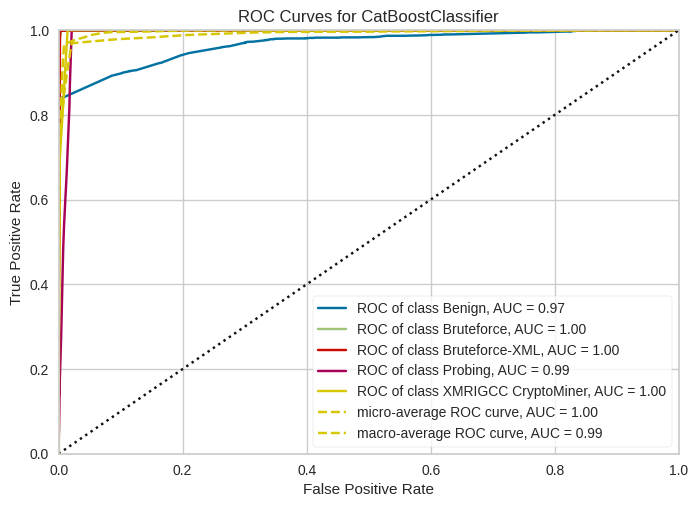

<Axes: title={'center': 'ROC Curves for CatBoostClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [15]:
model = wrap(cat)
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

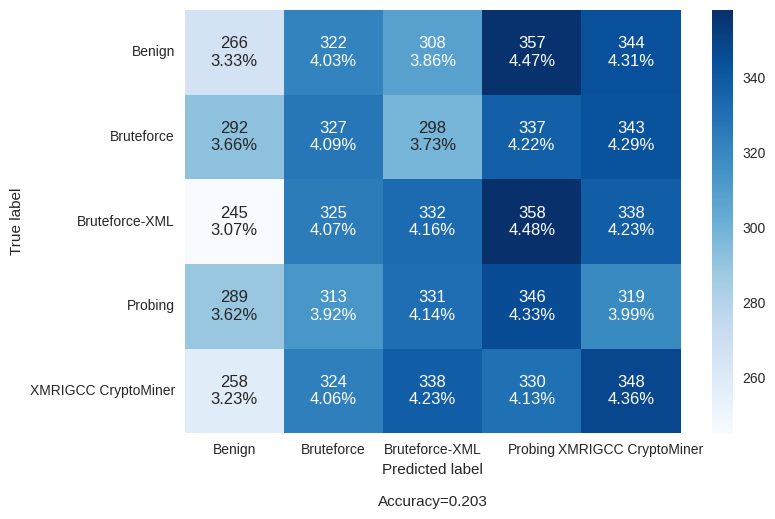

In [16]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(cat.classes_)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

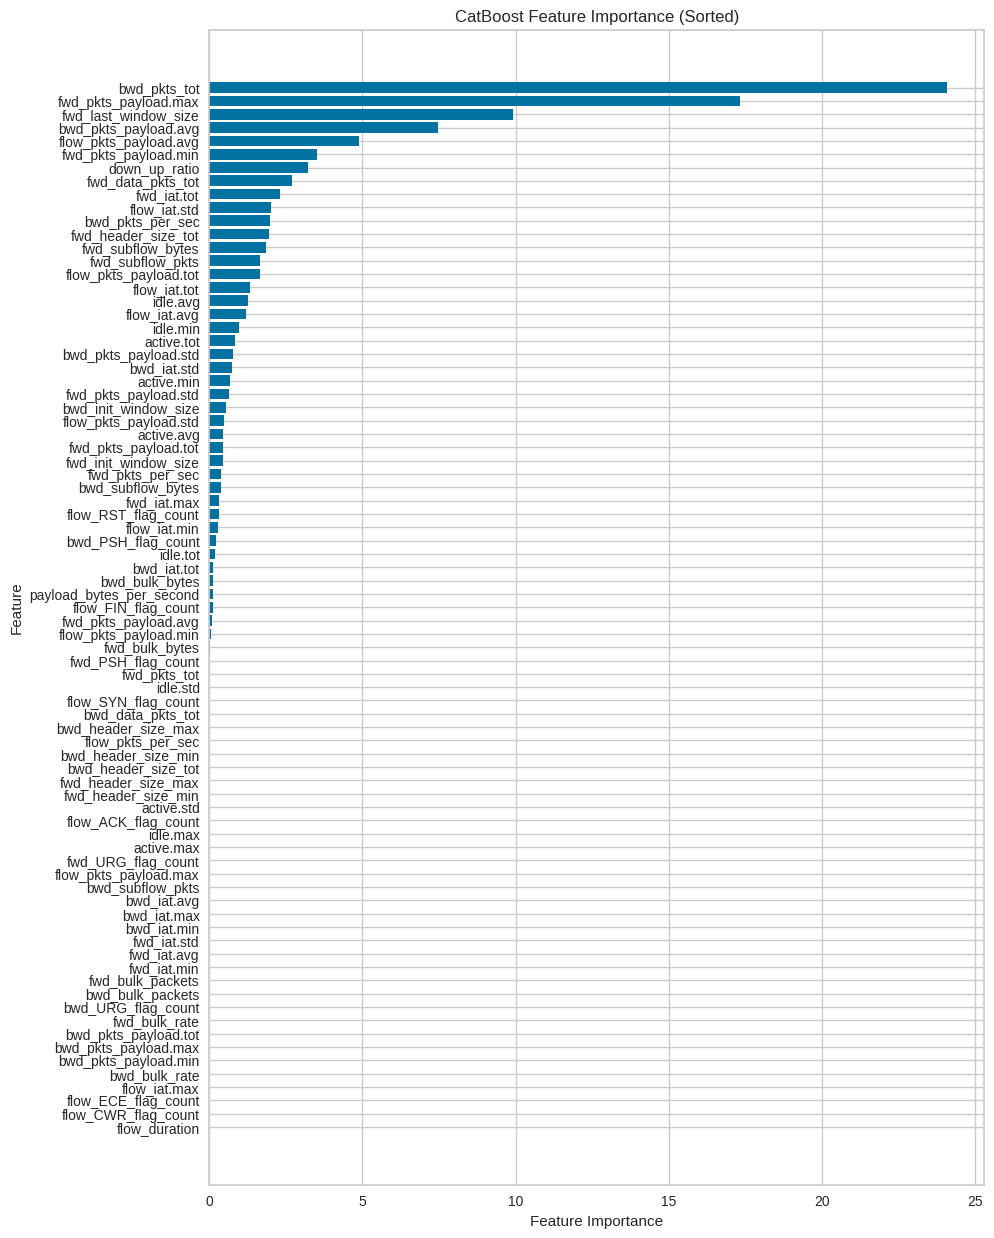

In [17]:
# Retrieve feature importance
feature_importance = model.get_feature_importance(type="FeatureImportance")
feature_names = X_train.columns

# Sort the features and feature importance scores
sorted_indices = np.argsort(feature_importance)
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot the sorted feature importance
plt.figure(figsize=(10, 15))
plt.barh(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance (Sorted)')
plt.show()

Using interventional to stay "true to the model" since we will use this data to do feature reduction and we want also to understand how things work

In [18]:
%%time

explainer = fasttreeshap.TreeExplainer(cat, algorithm='auto', n_jobs=-1) 
sv = explainer(X_train)

CPU times: user 4.84 s, sys: 185 ms, total: 5.03 s
Wall time: 1.92 s


In [19]:
cat.classes_

array(['Benign', 'Bruteforce', 'Bruteforce-XML', 'Probing',
       'XMRIGCC CryptoMiner'], dtype=object)

In [20]:
def make_plots(i):
    exp = Explanation(sv.values[:,:,i], 
                    sv.base_values[:,i], 
                    data=X_train, 
                    feature_names=x_features)

    plots.bar(exp, max_display=20, show=False)
    plt.show()
    plots.beeswarm(exp.abs, color="shap_red")
    plots.beeswarm(exp,order=exp.abs.max(0),max_display=5)
    plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)
    plots.bar(exp.abs.cohorts(2).mean(0))
    plots.heatmap(exp, instance_order=exp.sum(1))

## Benign shap

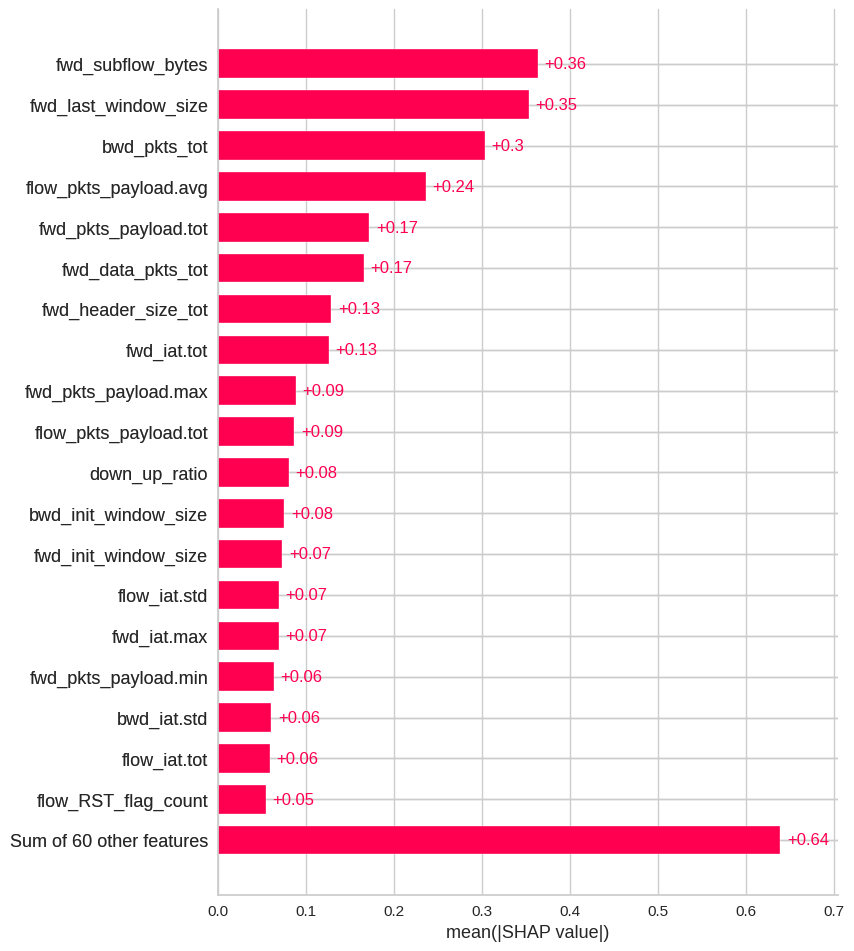

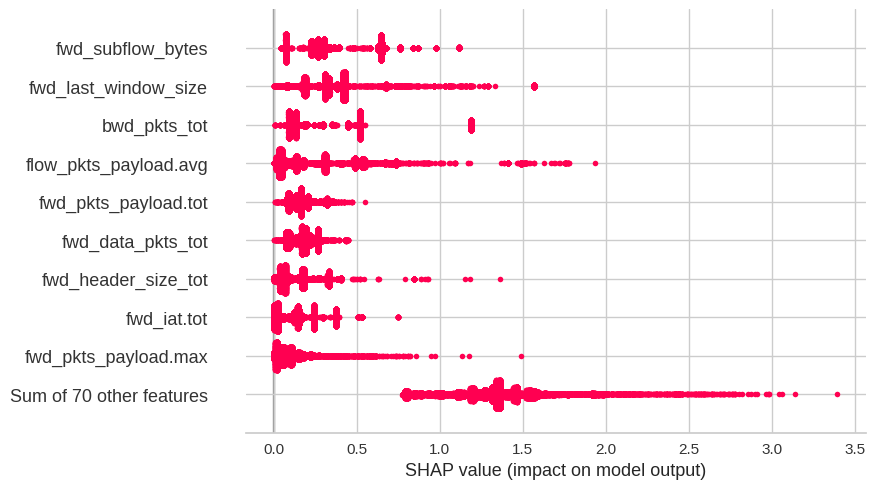

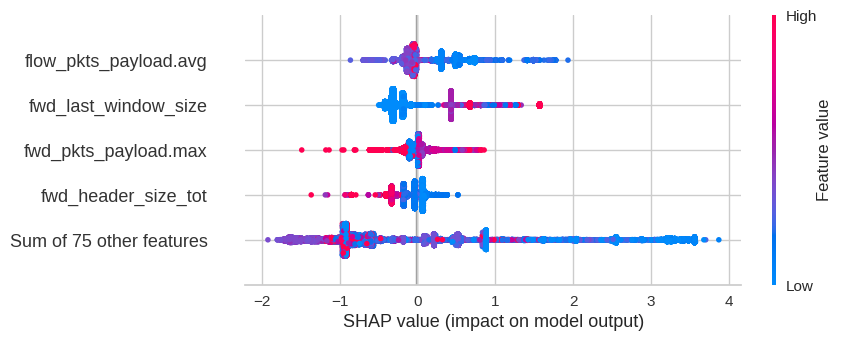

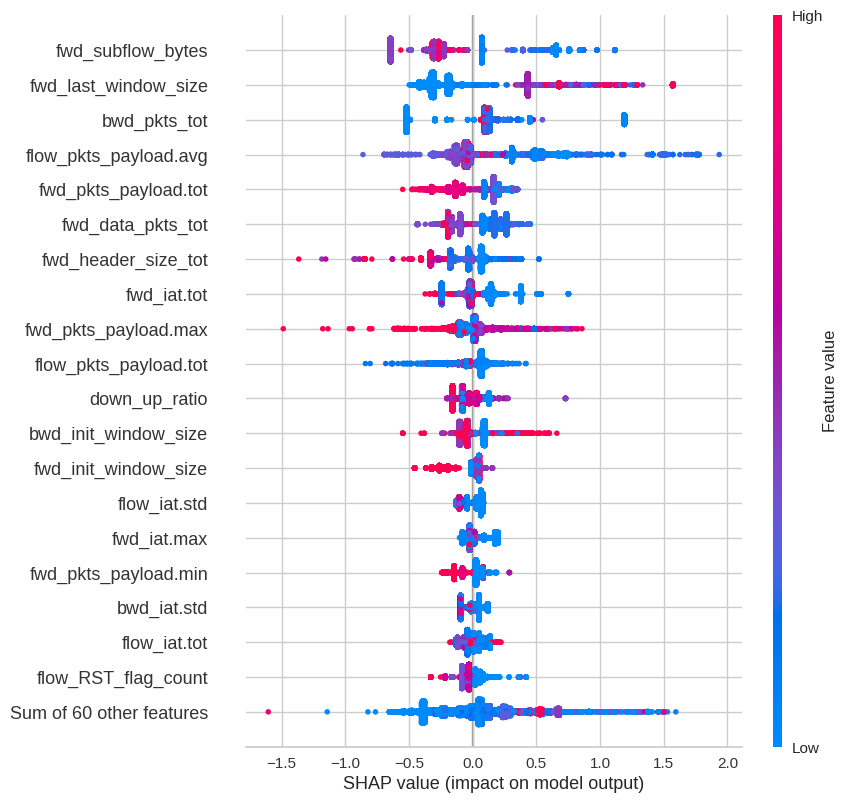

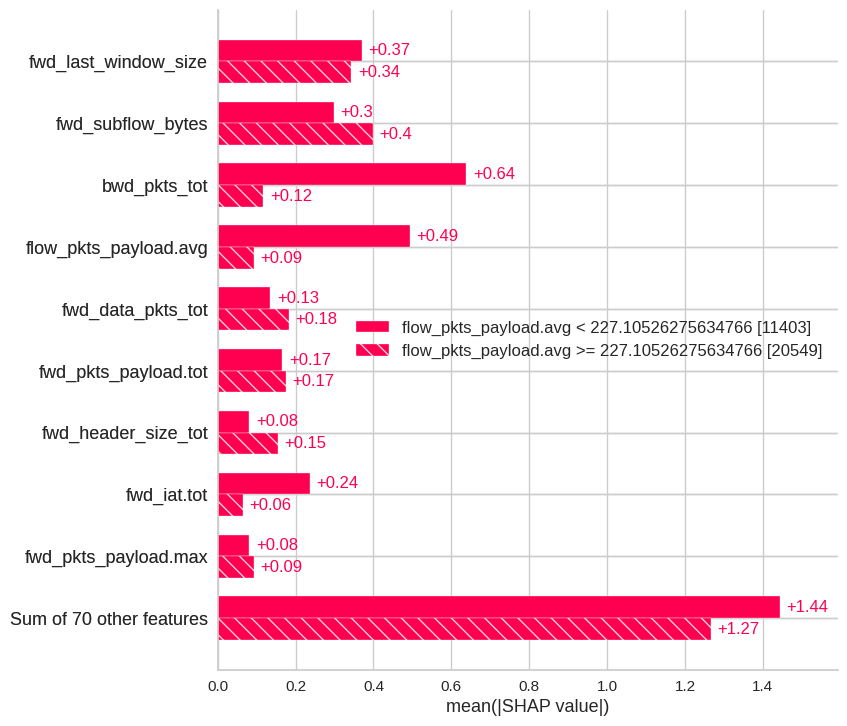

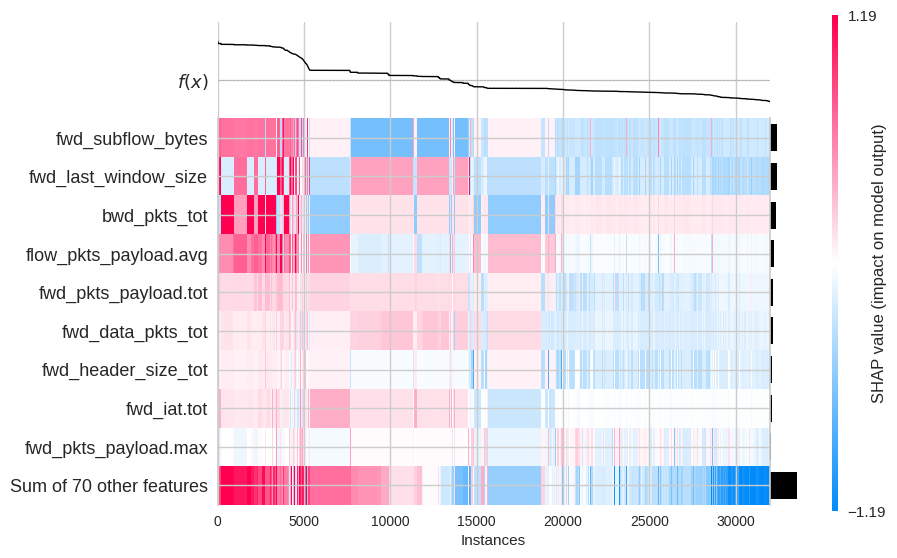

In [21]:
make_plots(0)

## Bruteforce shap

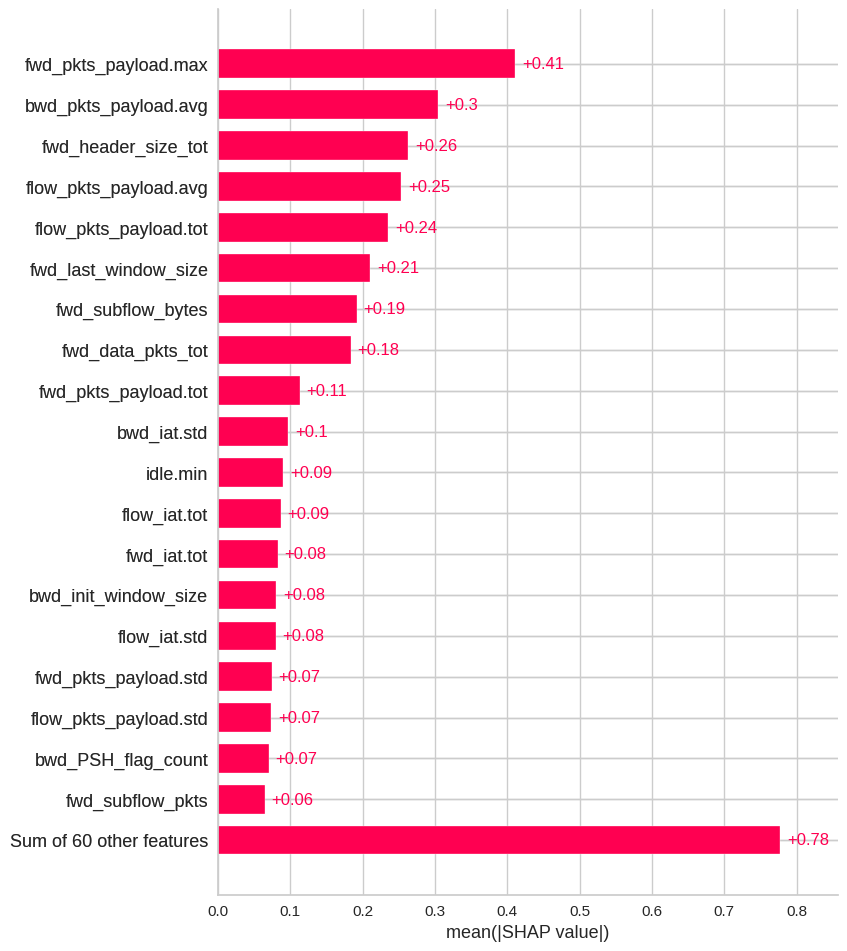

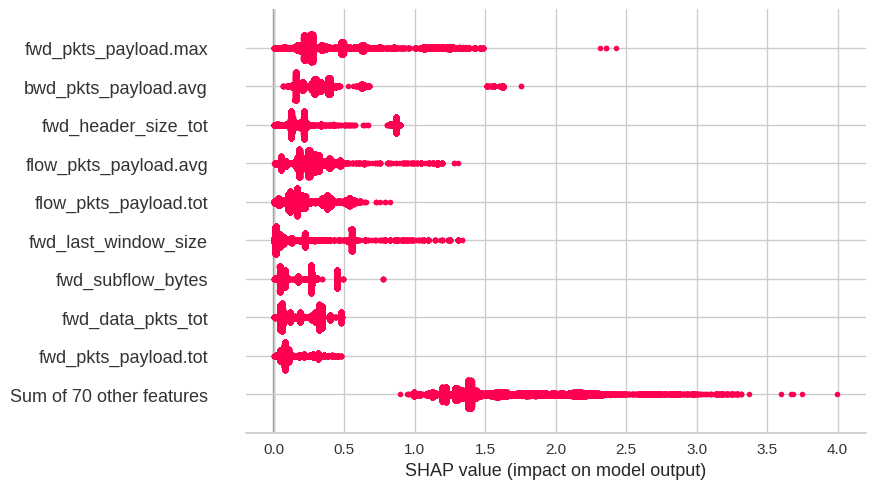

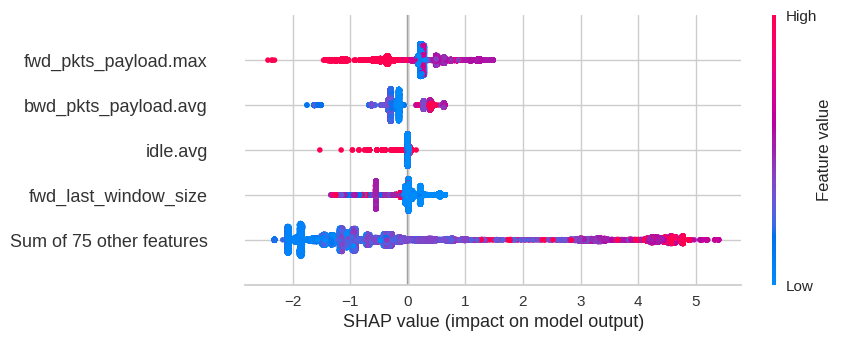

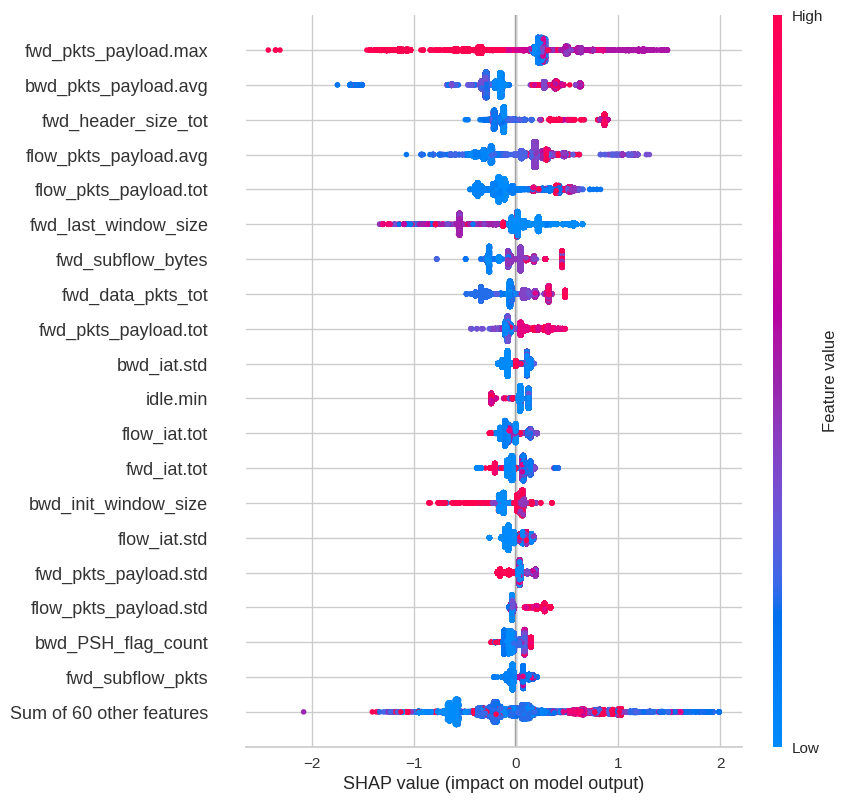

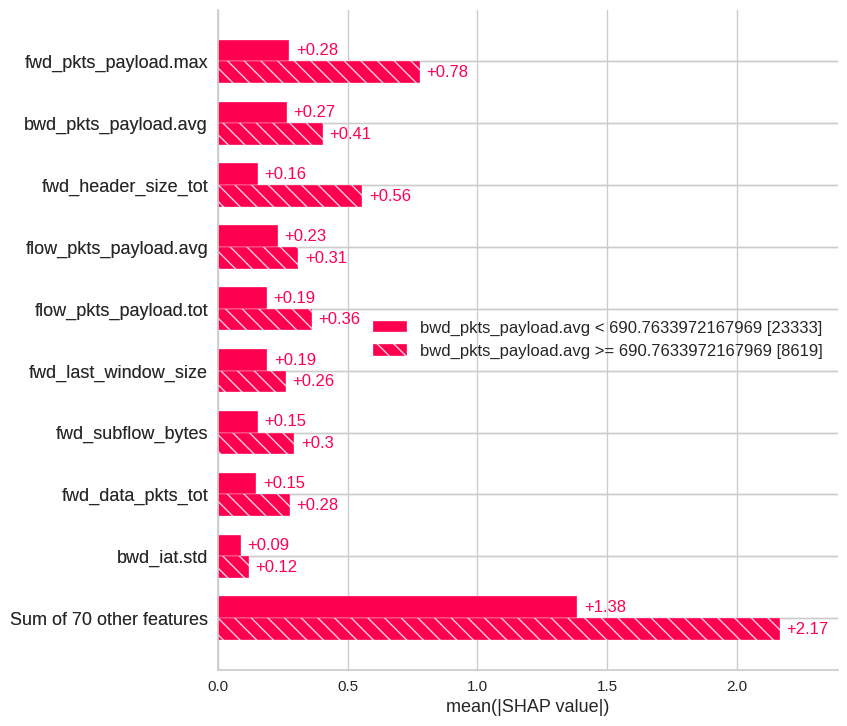

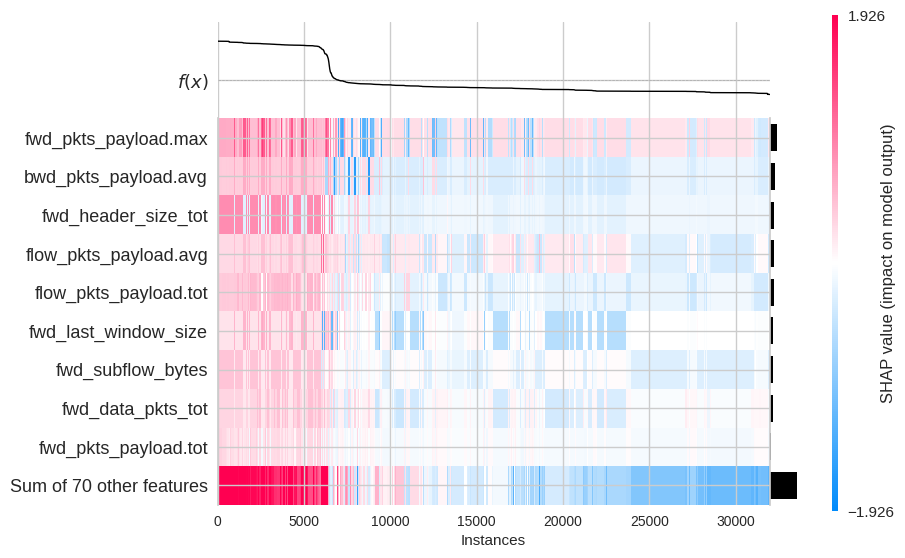

In [22]:
make_plots(1)

## Bruteforce XML shap

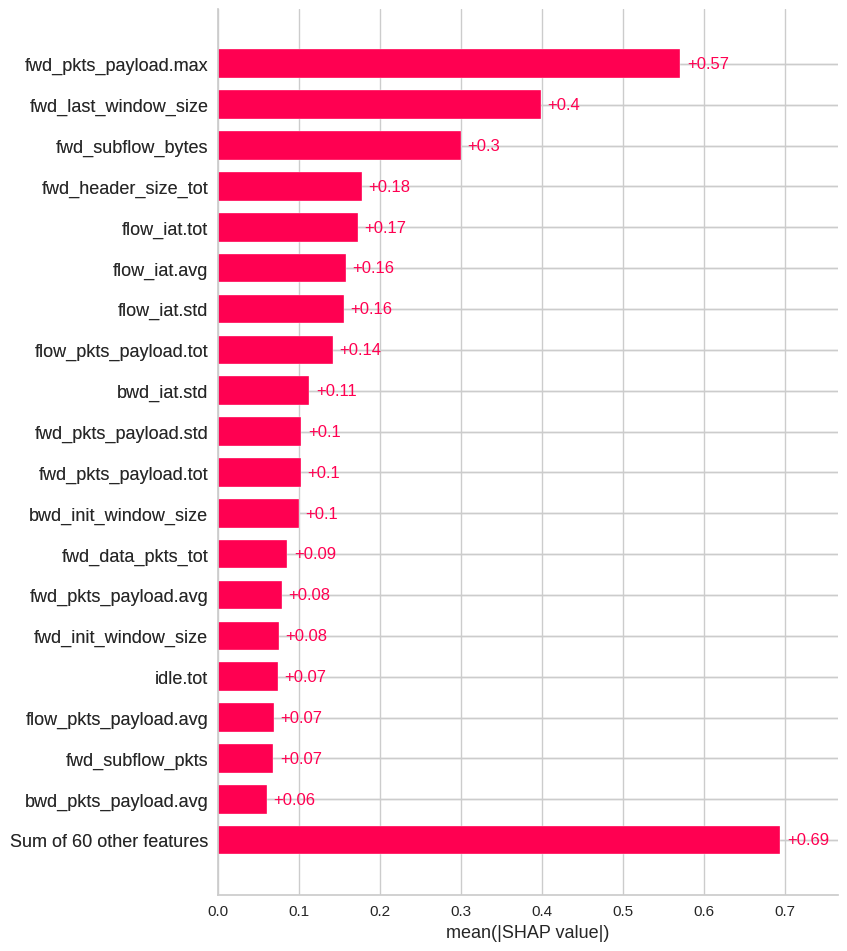

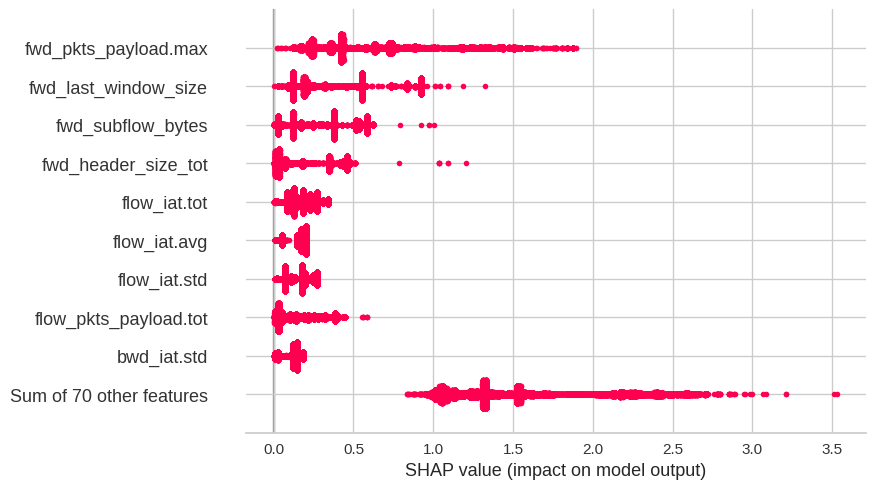

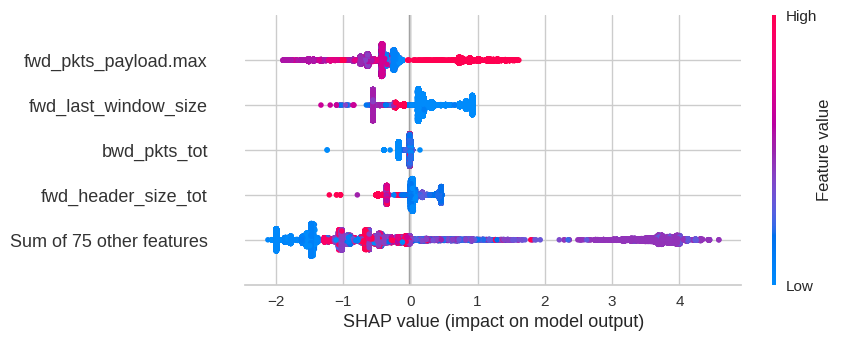

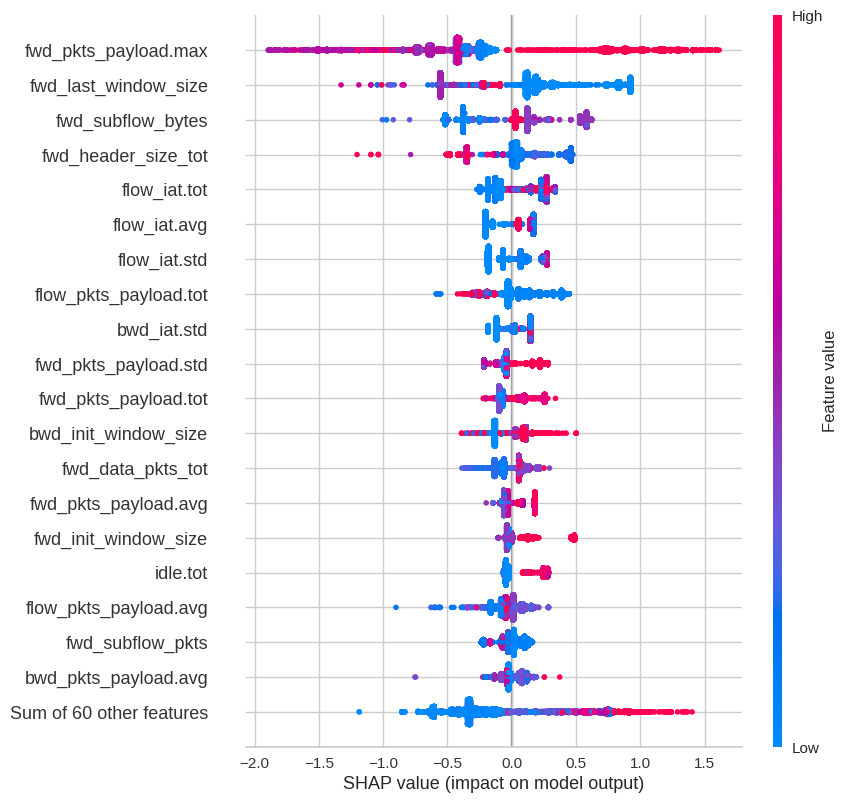

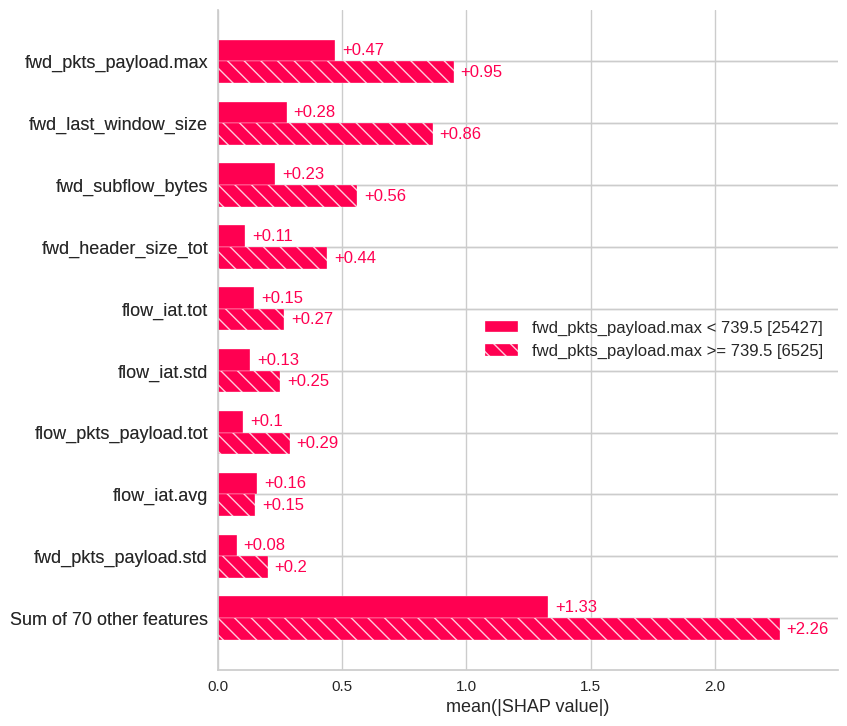

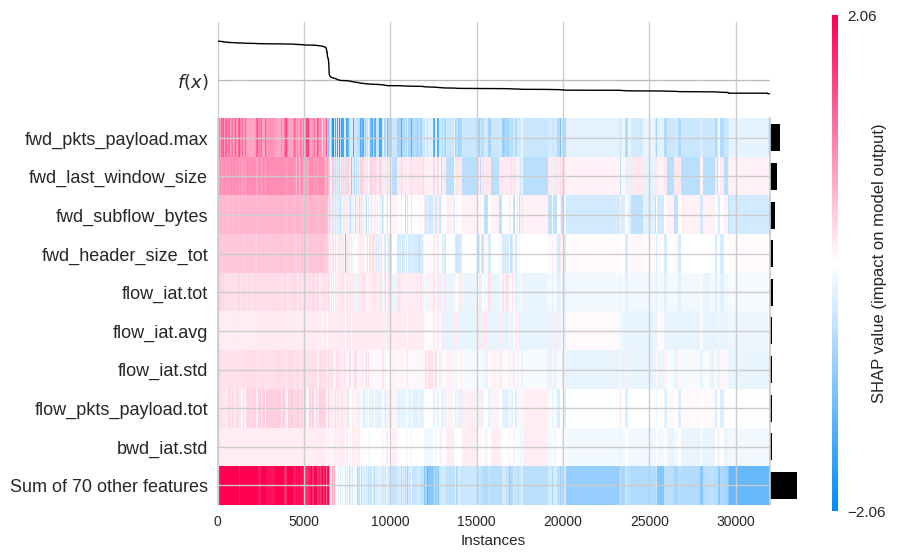

In [23]:
make_plots(2)

## Probing shap

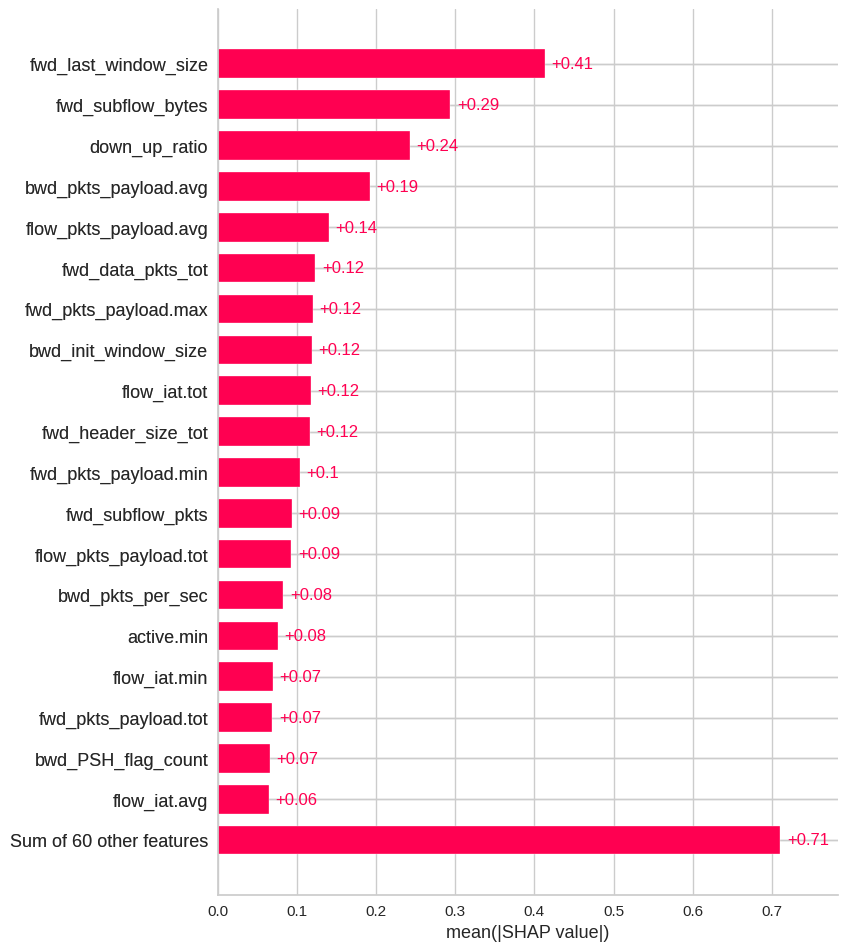

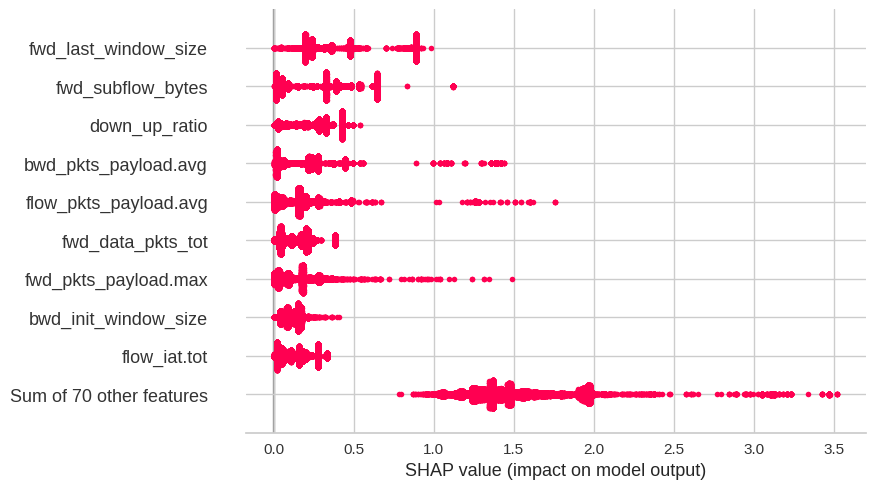

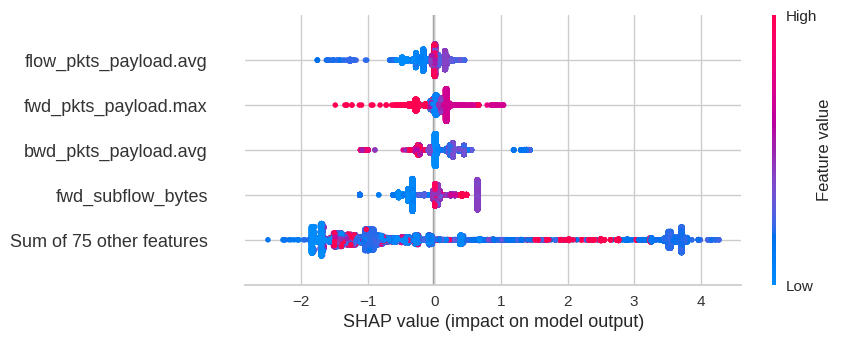

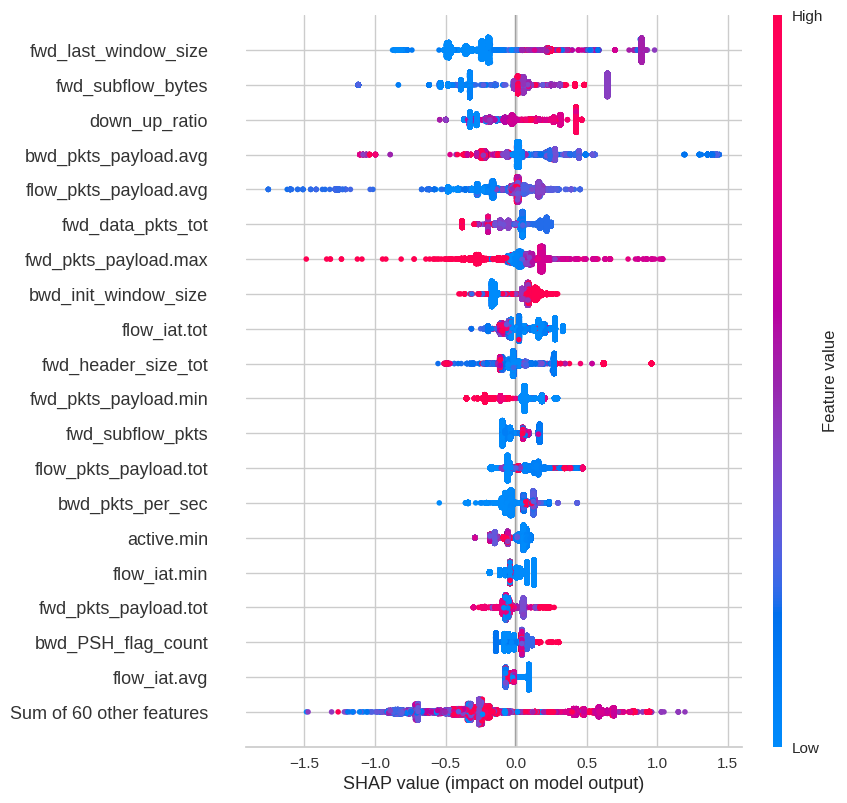

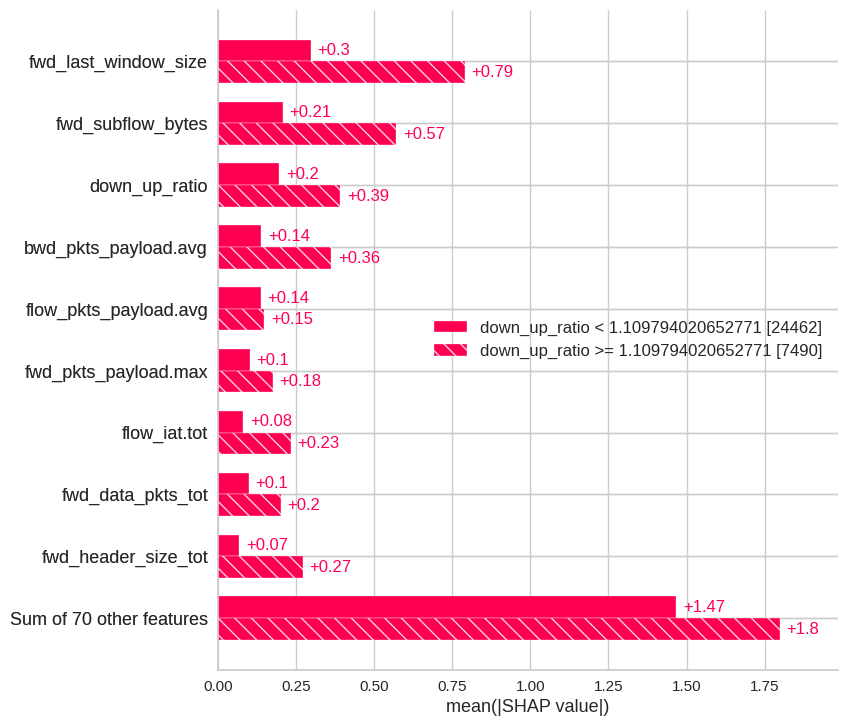

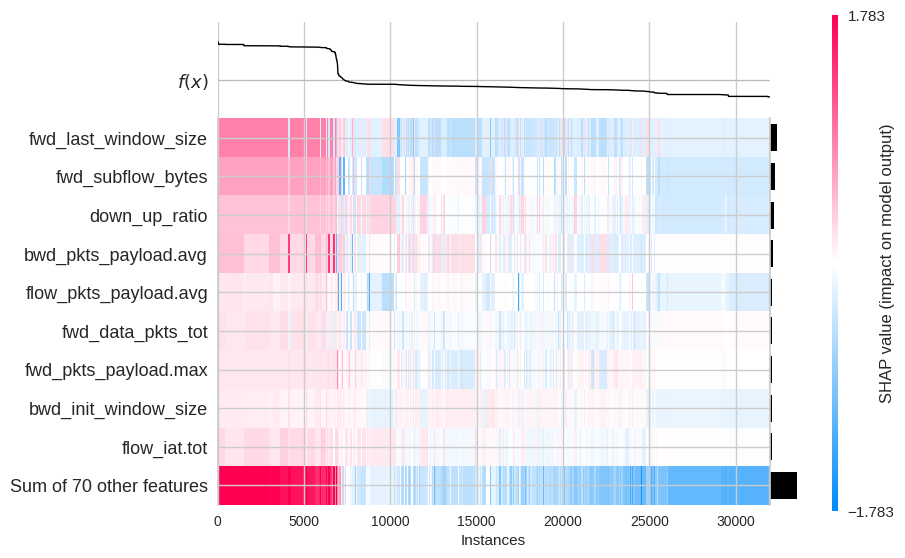

In [24]:
make_plots(3)

## Miner shap

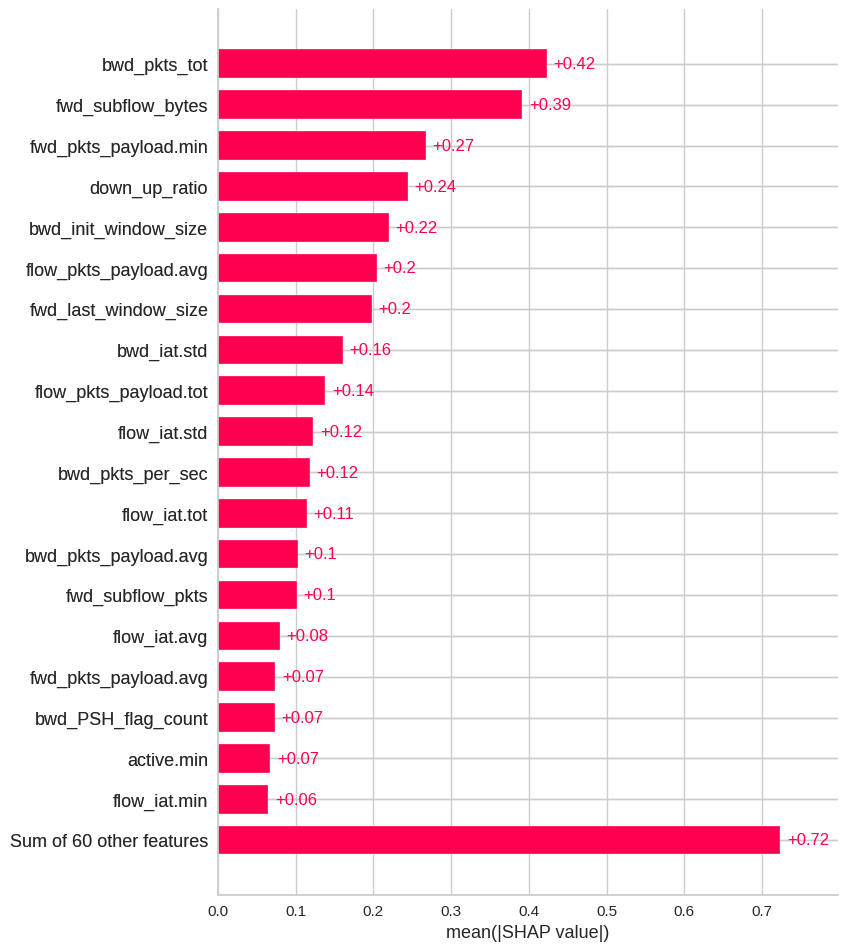

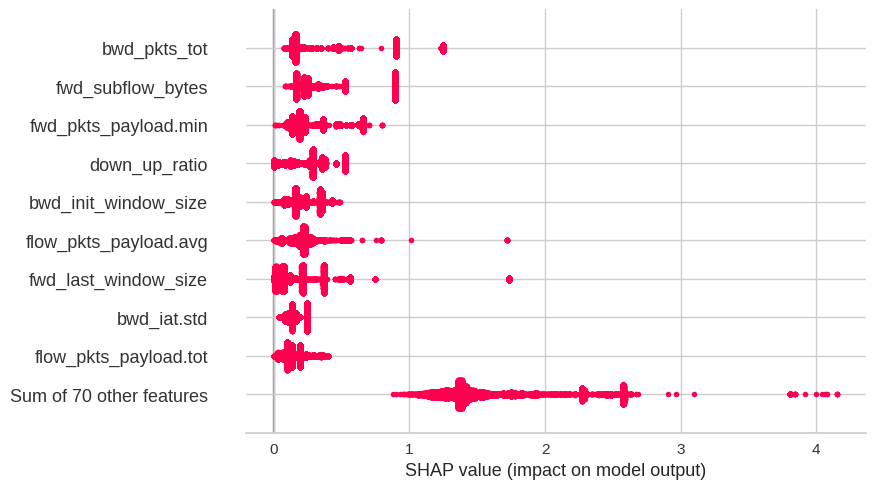

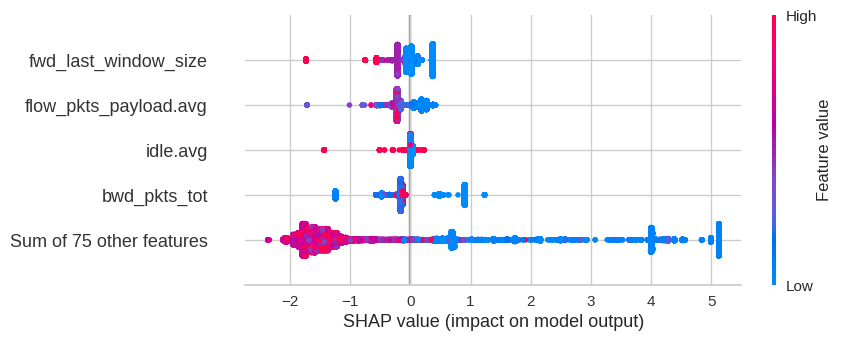

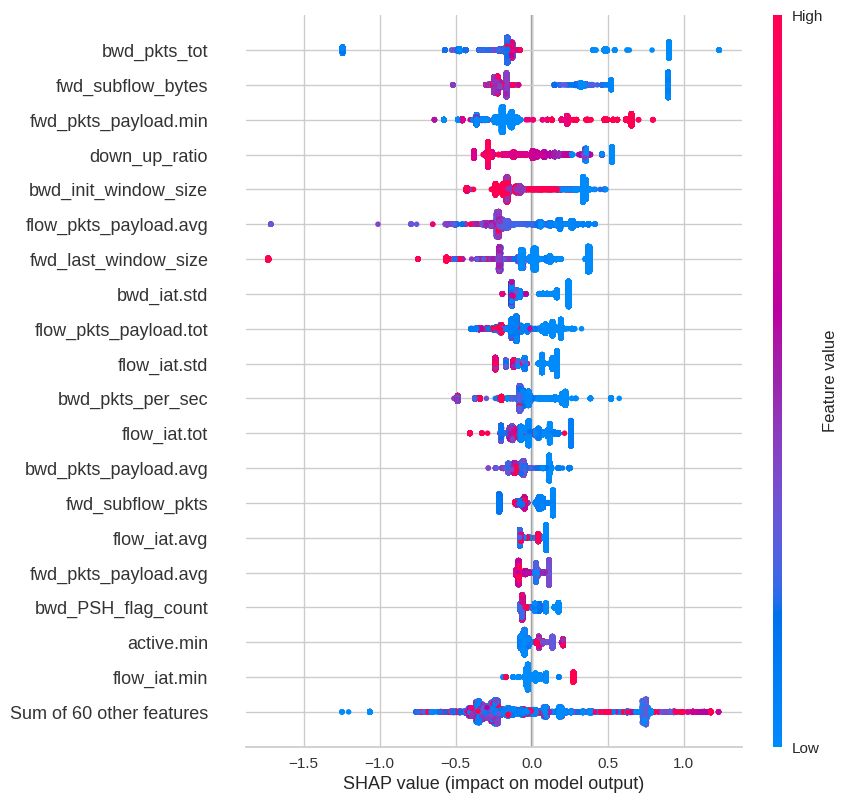

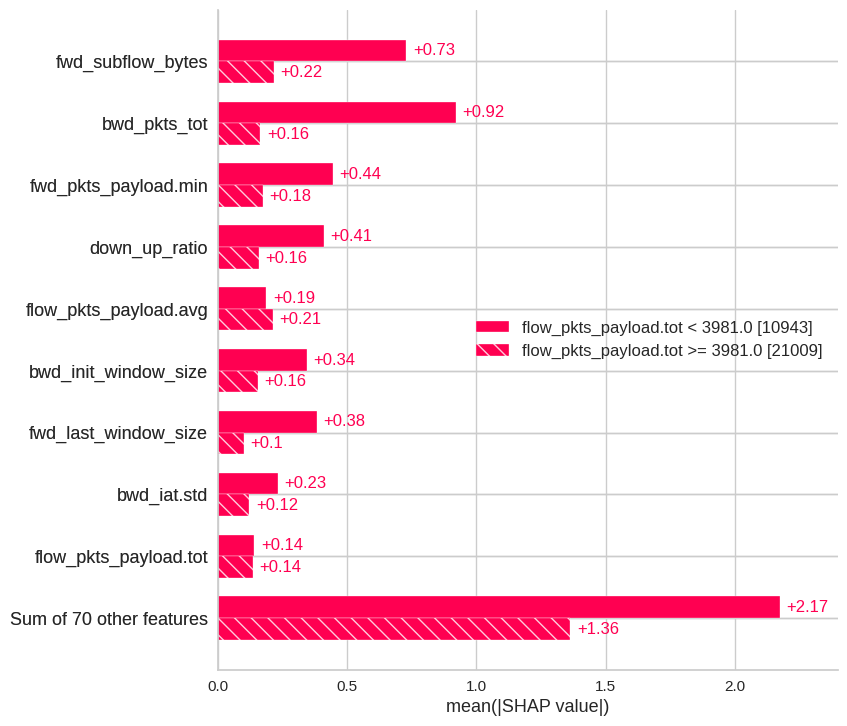

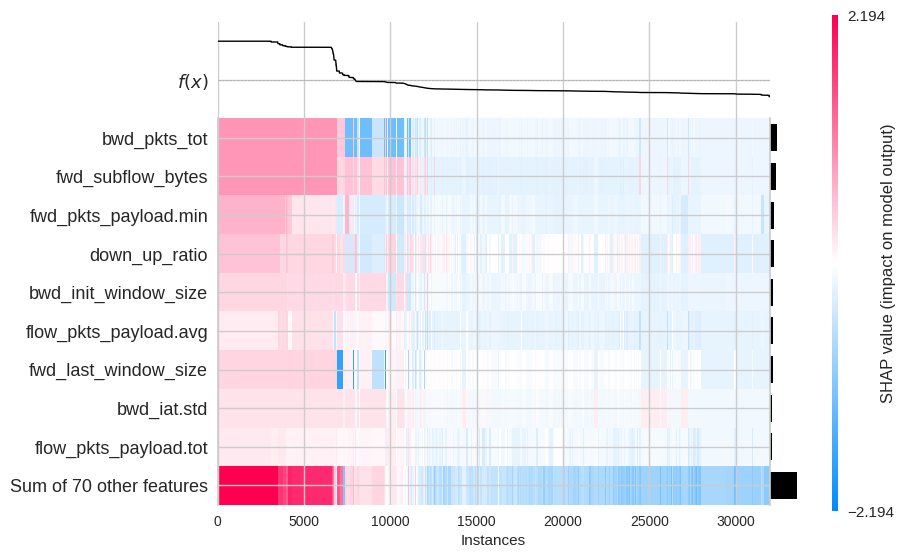

In [25]:
make_plots(4)

## Overall importance

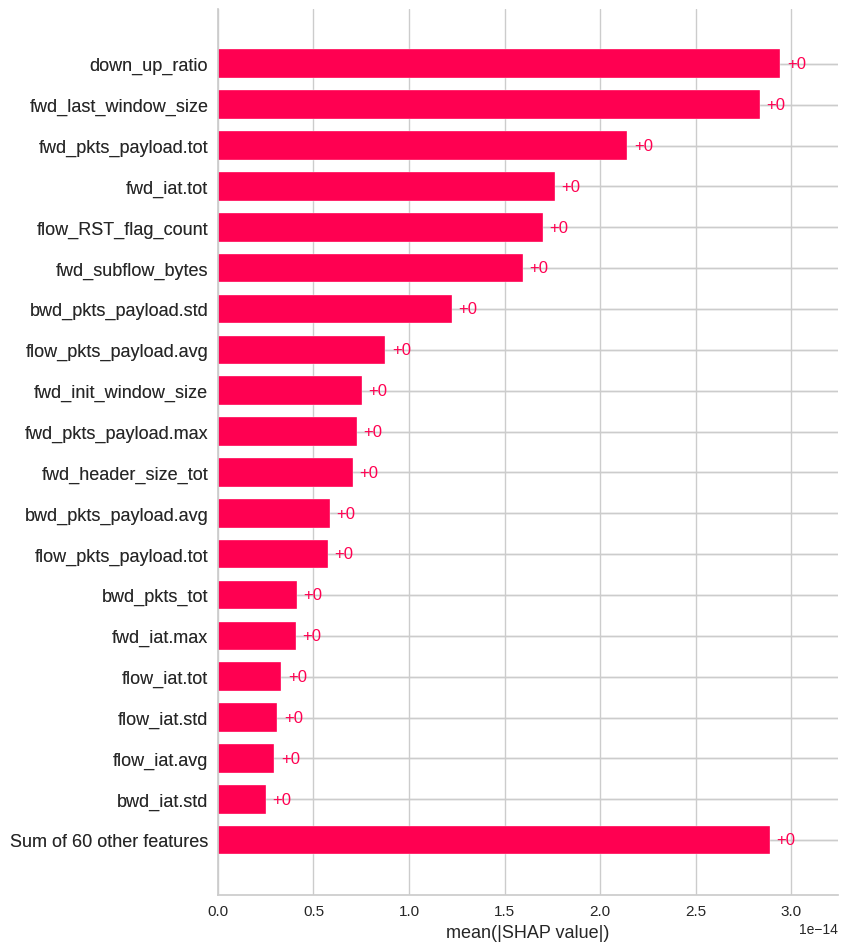

In [26]:
exp = Explanation(sv.values.mean(2), 
                  sv.base_values.mean(1), 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

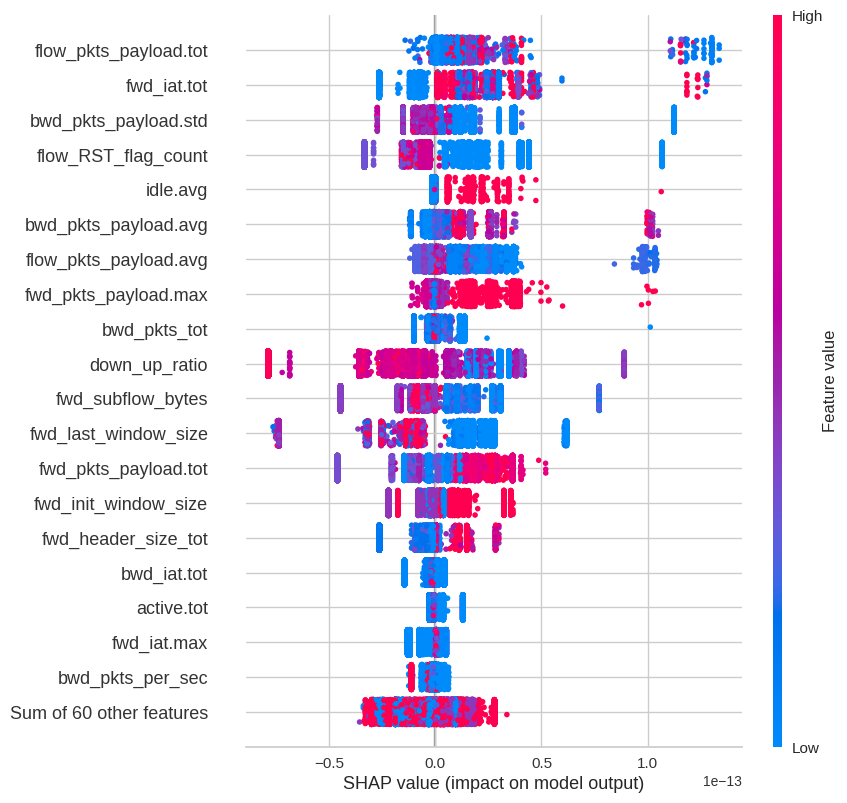

In [27]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

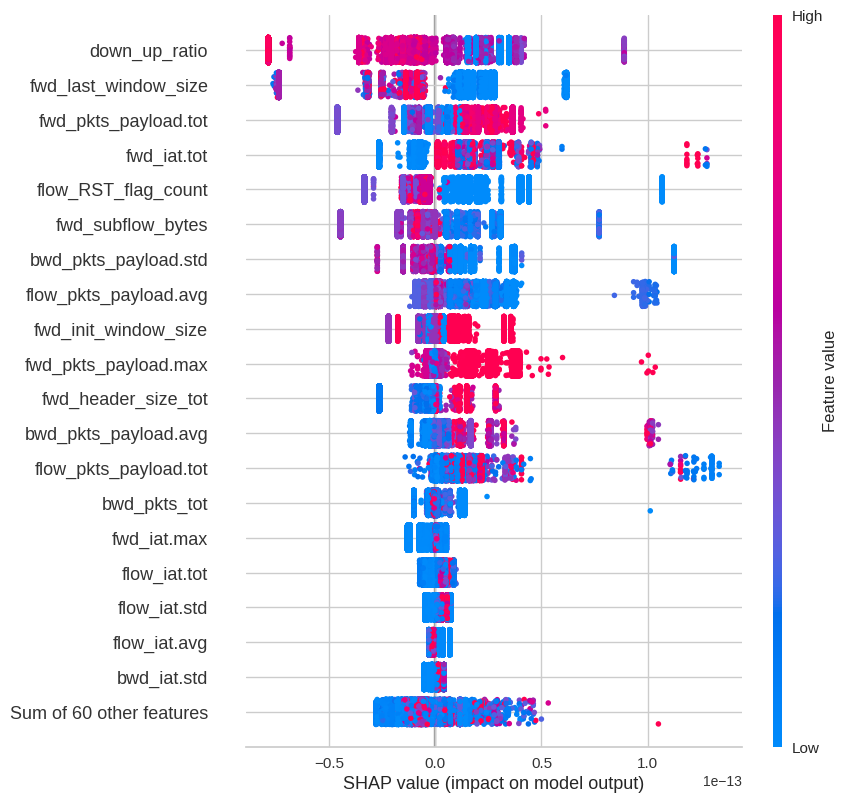

In [28]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

# Zero day test

In [29]:
classes = sorted(pd.unique(ds['traffic_category']).tolist())

In [30]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Bruteforce']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
cat.fit(X_train_attack, y_train_attack)
y_predicted_train = cat.predict(X_train_attack)
y_predicted_test = cat.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

0:	learn: 0.3719754	total: 71ms	remaining: 639ms
1:	learn: 0.2496764	total: 152ms	remaining: 607ms
2:	learn: 0.1941542	total: 233ms	remaining: 543ms
3:	learn: 0.1663566	total: 313ms	remaining: 470ms
4:	learn: 0.1503464	total: 398ms	remaining: 398ms
5:	learn: 0.1420105	total: 489ms	remaining: 326ms
6:	learn: 0.1367061	total: 580ms	remaining: 248ms
7:	learn: 0.1330414	total: 669ms	remaining: 167ms
8:	learn: 0.1311893	total: 767ms	remaining: 85.3ms
9:	learn: 0.1292766	total: 861ms	remaining: 0us


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Measure     Train      Test
0   ACCURACY  0.963303  0.767777
1  PRECISION  0.965431  0.661451
2     RECALL  0.963303  0.767777
3   F1 SCORE  0.962519  0.702695

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


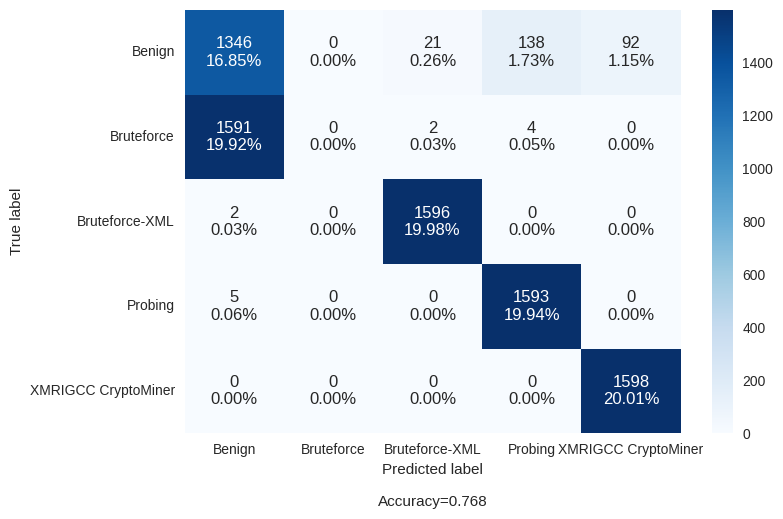

In [31]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [32]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Bruteforce-XML']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
cat.fit(X_train_attack, y_train_attack)
y_predicted_train = cat.predict(X_train_attack)
y_predicted_test = cat.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

0:	learn: 0.3973191	total: 76.7ms	remaining: 690ms
1:	learn: 0.2642392	total: 150ms	remaining: 598ms
2:	learn: 0.2064080	total: 223ms	remaining: 521ms
3:	learn: 0.1729179	total: 301ms	remaining: 451ms
4:	learn: 0.1563773	total: 388ms	remaining: 388ms
5:	learn: 0.1481763	total: 477ms	remaining: 318ms
6:	learn: 0.1428061	total: 577ms	remaining: 247ms
7:	learn: 0.1401622	total: 667ms	remaining: 167ms
8:	learn: 0.1367365	total: 757ms	remaining: 84.1ms
9:	learn: 0.1355799	total: 845ms	remaining: 0us


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Measure     Train      Test
0   ACCURACY  0.962757  0.767902
1  PRECISION  0.964953  0.635225
2     RECALL  0.962757  0.767902
3   F1 SCORE  0.961908  0.691541

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


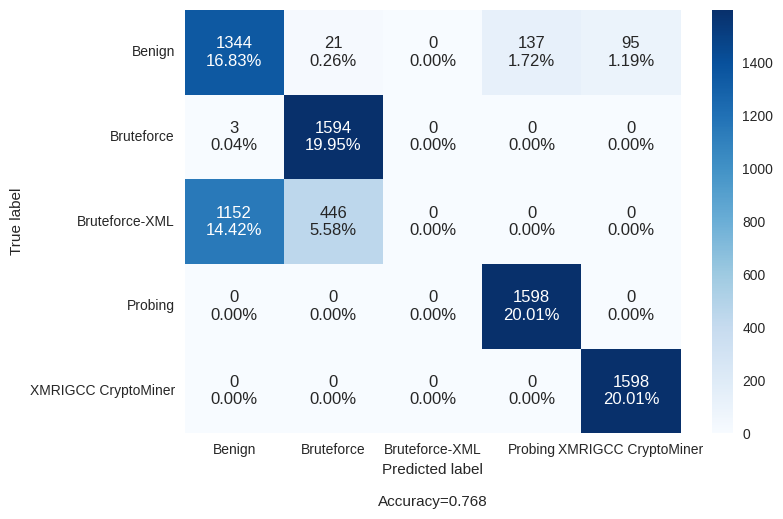

In [33]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [34]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Probing']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
cat.fit(X_train_attack, y_train_attack)
y_predicted_train = cat.predict(X_train_attack)
y_predicted_test = cat.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

0:	learn: 0.3347567	total: 68.7ms	remaining: 619ms
1:	learn: 0.2049015	total: 151ms	remaining: 605ms
2:	learn: 0.1444877	total: 235ms	remaining: 548ms
3:	learn: 0.1101905	total: 320ms	remaining: 480ms
4:	learn: 0.0954697	total: 406ms	remaining: 406ms
5:	learn: 0.0849702	total: 493ms	remaining: 328ms
6:	learn: 0.0800156	total: 592ms	remaining: 254ms
7:	learn: 0.0781396	total: 685ms	remaining: 171ms
8:	learn: 0.0749663	total: 769ms	remaining: 85.5ms
9:	learn: 0.0730233	total: 863ms	remaining: 0us


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Measure     Train      Test
0   ACCURACY  0.981574  0.782549
1  PRECISION  0.982124  0.679717
2     RECALL  0.981574  0.782549
3   F1 SCORE  0.981436  0.717050

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


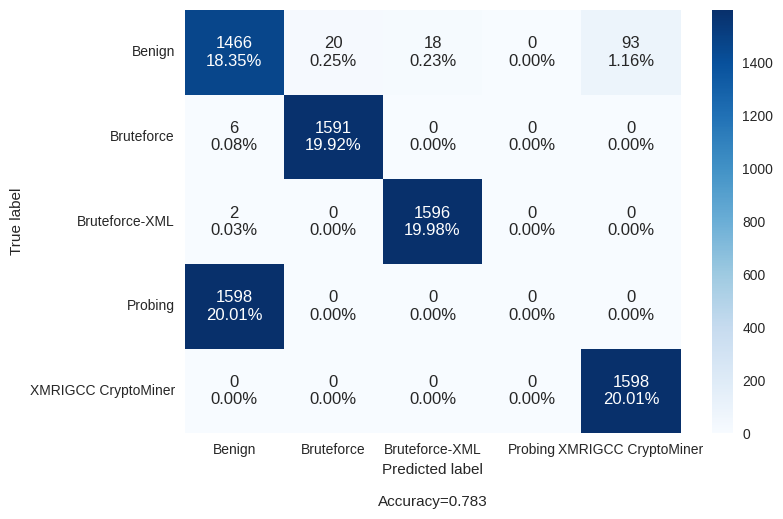

In [35]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [36]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'XMRIGCC CryptoMiner']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
cat.fit(X_train_attack, y_train_attack)
y_predicted_train = cat.predict(X_train_attack)
y_predicted_test = cat.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

0:	learn: 0.3432563	total: 111ms	remaining: 1s
1:	learn: 0.2231669	total: 213ms	remaining: 851ms
2:	learn: 0.1685700	total: 297ms	remaining: 692ms
3:	learn: 0.1392349	total: 385ms	remaining: 577ms
4:	learn: 0.1231565	total: 481ms	remaining: 481ms
5:	learn: 0.1155199	total: 574ms	remaining: 382ms
6:	learn: 0.1112557	total: 674ms	remaining: 289ms
7:	learn: 0.1079449	total: 772ms	remaining: 193ms
8:	learn: 0.1053712	total: 877ms	remaining: 97.5ms
9:	learn: 0.1038548	total: 984ms	remaining: 0us


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Measure     Train      Test
0   ACCURACY  0.972929  0.777291
1  PRECISION  0.974493  0.673564
2     RECALL  0.972929  0.777291
3   F1 SCORE  0.972670  0.712070

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


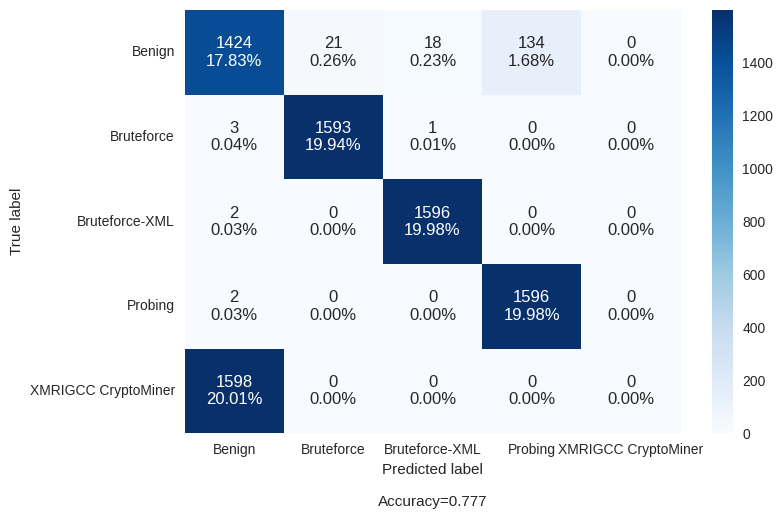

In [37]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')